In [25]:
from bokeh.palettes import viridis, inferno

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
output_notebook()

from bokeh.models import LogColorMapper, LogTicker, ColorBar
from astropy.timeseries import LombScargle

import matplotlib.pyplot as plt
#%matplotlib widget
# use seaborn for plot styles
import seaborn; seaborn.set()

from photofunc import *

Loading BokehJS ...

In [26]:
outputfile = 'outdir/out.photo'
columnfile = 'outdir/out.columns'


In [27]:
plotlc(outputfile,[189],columnfile,namelist=['189'])


sed '190q;d'  outdir/out.photo


In [28]:
datagoodmjd=  createdatadicclean(outputfile,189,columnfile,name='189',timeformat='mjd')
mjd, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

sed '190q;d'  outdir/out.photo


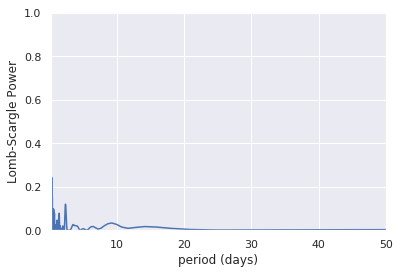

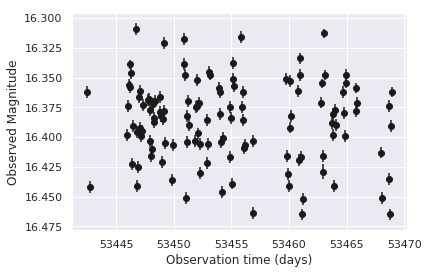

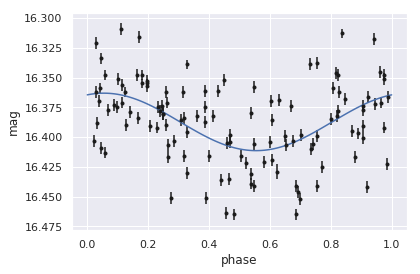

In [29]:


freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(mjd, mag, dmag).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

fig, ax = plt.subplots()

plt.plot(1. / freq, PLS)
ax.set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          xlim=(0.2, 50),
          ylim=(0, 1));
plt.show()


fig, ax = plt.subplots()

# plot the raw data
ax.errorbar(mjd, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax.invert_yaxis()
ax.set(   xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

#plt.plot(t,mag_fit)



fig, ax = plt.subplots()
# plot the phased data & model in the inset
plt.errorbar(phase, mag, dmag, fmt='.k', capsize=0)
plt.plot(phase_fit, mag_fit)


ax.invert_yaxis()
ax.set_xlabel('phase')
ax.set_ylabel('mag')
plt.show()

# Kaluzny

In [30]:
best_freq = freq[np.argmax(PLS)]

summary = 'Best_frequency: {}, Period: {}'.format(best_freq,1/best_freq)
print(summary)
p1 = figure(plot_width=900, plot_height=500, title=summary,active_drag='pan', active_scroll='wheel_zoom',y_axis_label='Power',x_axis_label='Period (days)')
p2 = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',y_axis_label='Power',x_axis_label='Freq (1/days)')


#source1 = ColumnDataSource(data={'power':PLS,
#                              'period': 1./freq})

period = 1./freq
source1 = ColumnDataSource(data={'power':PLS,
                              'period':1./freq,
                                'freq':freq})

#Tool to get wavelength
hover1 = HoverTool(
        tooltips=[
            ('Period', '(@period{0.0000}'),
            ('Frequency', '(@freq{0.000})')
        ]
    )


p1.add_tools(hover1)
p2.add_tools(hover1)



# add a circle renderer with a size, color, and alpha

p1.line('period','power',source=source1)
p2.line('freq','power',source=source1)

show(p1)
show(p2)

Best_frequency: 3.290475614247764, Period: 0.30390743382810637


In [31]:
colorlist = viridis(len(mjd))
colorlist = inferno(len(mjd))




p = figure(plot_width=900, plot_height=500, title=summary,active_drag='pan', active_scroll='wheel_zoom',y_axis_label='VEGAMAG',x_axis_label='Phase')


source = ColumnDataSource(data={'phase':phase,
                                'VEGAMAG':mag,
                                'dmag':dmag,
                                'mjd':mjd,
                               'upper':mag + dmag ,
              'lower':mag - dmag })
  


#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@mjd{0.0000})')
        ]
    )


p.add_tools(hover2)


# add a circle renderer with a size, color, and alpha
p.add_layout(
    Whisker(source=source, base="phase", upper="upper", lower="lower")
)

p.line(phase_fit, mag_fit)
p.y_range.flipped = True


mapper = LinearColorMapper(palette=colorlist, low=mjd.min(), high=mjd.max())

#mapper.low_color = 'blue'
#mapper.high_color = 'red'

color_bar = ColorBar(color_mapper=mapper, location=(0, 0.5),title='MJD')

p.circle('phase','VEGAMAG',source=source,color={'field': 'mjd', 'transform': mapper})


p.add_layout(color_bar, 'right')
#@date{%F}'

show(p)